In [1]:
!pip install yfinance streamlit yfinance pandas numpy matplotlib -qq

In [2]:
# To assign the plot settings to all plots
# Simply typing `rcparams()` in other python scripts will do the job.

import matplotlib.pyplot as plt
from matplotlib import rcParams

def rcparams():
    rcParams['figure.figsize'] = 5, 4
    rcParams['font.family'] = 'sans-serif'

    # Check whether Arial or SF Pro Display are installed in the computer
    try:
        rcParams['font.sans-serif'] = ['SF Pro Display']
    except:
        try:
            rcParams['font.sans-serif'] = ['Arial']
        except:
            print("ERROR Note that Arial and SF Pro are not installed in the computer. The program will use the default font.")
            pass

    # Label should be far away from the axes
    rcParams['axes.labelpad'] = 8
    rcParams['xtick.major.pad'] = 7
    rcParams['ytick.major.pad'] = 7

    # Add minor ticks
    rcParams['xtick.minor.visible'] = True
    rcParams['ytick.minor.visible'] = True

    # Tick width
    rcParams['xtick.major.width'] = 1
    rcParams['ytick.major.width'] = 1
    rcParams['xtick.minor.width'] = 0.5
    rcParams['ytick.minor.width'] = 0.5

    # Tick length
    rcParams['xtick.major.size'] = 5
    rcParams['ytick.major.size'] = 5
    rcParams['xtick.minor.size'] = 3
    rcParams['ytick.minor.size'] = 3

    # Tick color
    rcParams['xtick.color'] = 'black'
    rcParams['ytick.color'] = 'black'

    rcParams['font.size'] = 14
    rcParams['axes.titlepad'] = 10
    rcParams['axes.titleweight'] = 'normal'
    rcParams['axes.titlesize'] = 18

    # Axes settings
    rcParams['axes.labelweight'] = 'normal'
    rcParams['xtick.labelsize'] = 12
    rcParams['ytick.labelsize'] = 12
    rcParams['axes.labelsize'] = 16
    rcParams['xtick.direction'] = 'in'
    rcParams['ytick.direction'] = 'in'

**Main code**

In [21]:
"""basic logic
1. 매달 (every month) 1,000 $ 만큼의 voo를 적립한다. 타이밍은 상관 없다. 월급날은 1일이고, 월급날에 voo를 매번 적립해야 한다. 
2. ixic 차트의 하방 채널을 최초로 터치한다면, voo를 **전량 매도**하고 tqqq로 종목을 옮긴다. 이 때부터는 월급을 받으면 tqqq에 적립한다. 
3. spx가 -3% 이상 하락한다면, 다음 날 tqqq를 **전량 매도**하고 voo로 종목을 옮긴다. 이 때부터는 월급을 받으면 voo에 적립한다. 

즉, ixic와 spx가 voo / tqqq 종목 변화를 위한 주요 트리거가 되는데, 
- ixic의 경우 -> 하방 채널을 터치한다
- spx의 경우 -> -3%의 하락세를 보인다
일 경우 월급으로 적립해야 할 품목을 tqqq / voo로 토글하면 된다. 
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_first_trading_day_of_month(data):
    return data.resample('M').first().dropna().index

def simulate_investment(start_date, end_date): 
    # Data loading
    voo_data = yf.download('VOO', start_date, end_date)
    ixic_data = yf.download('^IXIC', start_date, end_date)
    spx_data = yf.download('^GSPC', start_date, end_date)
    tqqq_data = yf.download('TQQQ', start_date, end_date)

    # 1. ixic 하방 채널 기준 
    ixic_data['MA20'] = ixic_data['Close'].rolling(window=100).mean()
    ixic_data['stddev'] = ixic_data['Close'].rolling(window=100).std()
    ixic_data['upper'] = ixic_data['MA20'] + (ixic_data['stddev'] * 2)
    ixic_data['lower'] = ixic_data['MA20'] - (ixic_data['stddev'] * 2)

    # Window = 100 is reasonble 

    # 2. spx -3% 하락 여부 기준
    is_spx_below_three = spx_data['Close'].pct_change().rolling(window=2).sum() < -0.03

    # CASE 1: 투자를 했을 때의 자산 
    # 월급
    monthly_income = 1000

    # Identify the first trading day of each month
    first_trading_days = voo_data.asfreq('BM').dropna().index

    # 자산 상태 초기화
    holding_voo = True  # 처음에는 VOO를 보유하고 시작
    voo_shares = 0
    tqqq_shares = 0
    cash = 0
    cash_accumulated = 0  # 월급만 모았을 때의 총 금액

    # 결과를 저장할 데이터프레임 생성
    results_df = pd.DataFrame(index=ixic_data.index, columns=['Total_Value', 'Cash_Accumulated'])

    # 날짜별로 루프 실행
    # first_trading_days = get_first_trading_day_of_month(voo_data)
    for next_trading_day in ixic_data.index:
        if next_trading_day in first_trading_days:
            # 월급 투자 실행
            cash_accumulated += monthly_income

            if holding_voo:
                cash += monthly_income
                voo_price = voo_data.loc[next_trading_day, 'Close'] if next_trading_day in voo_data.index else np.nan
                voo_shares += cash // voo_price
                cash %= voo_price
            else:
                cash += monthly_income
                tqqq_price = tqqq_data.loc[next_trading_day, 'Close'] if next_trading_day in tqqq_data.index else np.nan
                tqqq_shares += cash // tqqq_price
                cash %= tqqq_price

        # IXIC이 하방 채널을 터치하면 VOO 매도 후 TQQQ 매수
        if ixic_data.loc[next_trading_day, 'Close'] <= ixic_data.loc[next_trading_day, 'lower'] and holding_voo:
            voo_price = voo_data.loc[next_trading_day, 'Close']
            cash += voo_shares * voo_price
            voo_shares = 0
            tqqq_price = tqqq_data.loc[next_trading_day, 'Close']
            tqqq_shares += cash // tqqq_price
            cash %= tqqq_price
            holding_voo = False

        # SPX가 -3% 이상 하락하면 TQQQ 매도 후 VOO 매수
        if is_spx_below_three.loc[next_trading_day] and not holding_voo:
            tqqq_price = tqqq_data.loc[next_trading_day, 'Close']
            cash += tqqq_shares * tqqq_price
            tqqq_shares = 0
            voo_price = voo_data.loc[next_trading_day, 'Close']
            voo_shares += cash // voo_price
            cash %= voo_price
            holding_voo = True

        # 현재 날짜의 총 자산 가치 계산
        if holding_voo:
            voo_price = voo_data.loc[next_trading_day, 'Close'] if next_trading_day in voo_data.index else np.nan
            total_value = voo_shares * voo_price + cash
        else:
            tqqq_price = tqqq_data.loc[next_trading_day, 'Close'] if next_trading_day in tqqq_data.index else np.nan
            total_value = tqqq_shares * tqqq_price + cash

        # 데이터프레임에 결과 저장
        results_df.loc[next_trading_day, 'Total_Value'] = total_value
        results_df.loc[next_trading_day, 'Cash_Accumulated'] = cash_accumulated

        # 제일 
        if next_trading_day >= ixic_data.index[-10]:
            print(next_trading_day, f'VOO 보유: {holding_voo}', f'VOO 보유량: {voo_shares} 주', 
                        f'TQQQ 보유량: {tqqq_shares} 주', f'현금: {cash} 불', f'총 자산: {total_value} 불', 
                        f'월급만 모았을 때의 총 금액: {cash_accumulated} 불', sep='\n', end='\n\n')

    results_df.to_csv(f'investment_simulation_{start_date}_to_{end_date}.csv')

    # 플롯 후 저장
    rcparams()

    # After the loop, save the results and plot
    results_df.to_csv(f'investment_simulation_{start_date}_to_{end_date}.csv')
    plt.figure(figsize=(8, 5))
    plt.plot(results_df.index, results_df['Total_Value'], label='With investment', color='blue')
    plt.plot(results_df.index, results_df['Cash_Accumulated'], label='Without investment', color='orange')
    leg = plt.legend(frameon=True, facecolor='white', edgecolor='black') 
    for text, color in zip(leg.get_texts(), ['blue', 'orange']):
        text.set_color(color)
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.title(f'Backtesting from {start_date} to {end_date}')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.savefig(f'investment_simulation_{start_date}_to_{end_date}.png', dpi=300)

    # Alert the user
    print(f'INFO: The results are saved as investment_simulation_{start_date}_to_{end_date}.csv and investment_simulation_{start_date}_to_{end_date}.png !')

    return results_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
2021-12-16 00:00:00
VOO 보유: True
VOO 보유량: 25.0 주
TQQQ 보유량: 0 주
현금: 335.0301208496094 불
총 자산: 11056.030029296875 불
월급만 모았을 때의 총 금액: 10000 불

2021-12-17 00:00:00
VOO 보유: True
VOO 보유량: 25.0 주
TQQQ 보유량: 0 주
현금: 335.0301208496094 불
총 자산: 10944.780487060547 불
월급만 모았을 때의 총 금액: 10000 불

2021-12-20 00:00:00
VOO 보유: True
VOO 보유량: 25.0 주
TQQQ 보유량: 0 주
현금: 335.0301208496094 불
총 자산: 10830.029815673828 불
월급만 모았을 때의 총 금액: 10000 불

2021-12-21 00:00:00
VOO 보유: True
VOO 보유량: 25.0 주
TQQQ 보유량: 0 주
현금: 335.0301208496094 불
총 자산: 10977.280181884766 불
월급만 모았을 때의 총 금액: 10000 불

2021-12-22 00:00:00
VOO 보유: True
VOO 보유량: 25.0 주
TQQQ 보유량: 0 주
현금: 335.0301208496094 불
총 자산: 11084.779876708984 불
월급만 모았을 때의 총 금액: 10000 불

2021-12-23 00:00:00
VOO 

,Total_Value,Cash_Accumulated
Date,,
2021-01-04,0.0,0
2021-01-05,0.0,0
2021-01-06,0.0,0
2021-01-07,0.0,0
2021-01-08,0.0,0
...,...,...
2021-12-23,11151.030487,10000
2021-12-27,11305.28006,10000
2021-12-28,11297.030396,10000


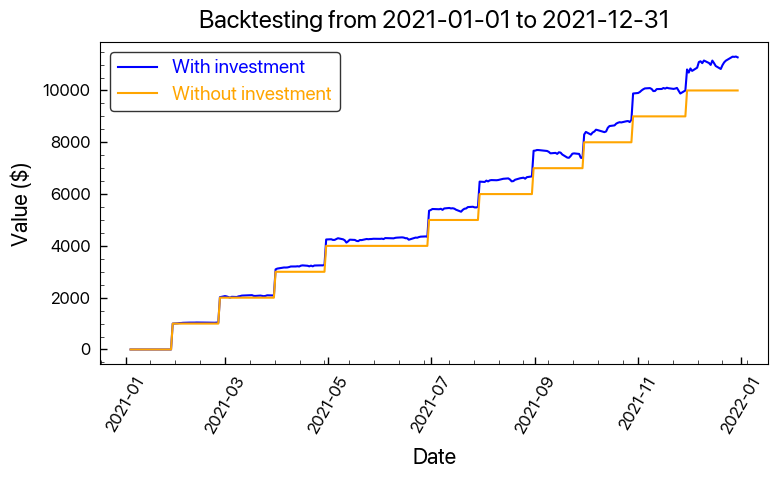

In [34]:
# Call the function with any start and end date
start_date = '2021-01-01'
end_date = '2021-12-31'
simulate_investment(start_date, end_date)